# Medicare Fraud - Outpatient Exploratory Data Analysis

Mustapha Mbengue, Peyton Nash, Bradley Stoller, Kyler Rosen

3/9/25

Purpose: Conducts exploratory data analysis on the outpatient data.

# Import Library

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

# Function Library

In [ ]:
def eda_results(df, df_name, numerical_cols, categorical_cols):
    """
    Perform an EDA of the provided dataframe.
    """
    print(f"=== EDA Summary for {df_name} ===\n")
    
    print("Shape:", df.shape)
    print("Info:")
    print(df.info())
    check_missing(df)
    print("\nDuplicate Rows:", df.duplicated().sum())

    print("\nSummary Statistics:")
    df.describe().T

    print("\nColumn Types:\n", df.dtypes.value_counts())

    print('Numerical Disribution Analysis:')
    numerical_distribution_analysis(df, df_name, numerical_cols)

    print('Categorical Disribution Analysis:')
    categorical_distribution_analysis(df, df_name, categorical_cols)

    print('Final Summary:')
    attribute_characteristics(df, df_name)

def check_missing(df):
    print('Missing Value Analysis:')
    df_missing = pd.DataFrame(df.isna().sum(), columns=['Missing Values (count)'])
    df_missing['Missing Values (pct)'] = round(df_missing['Missing Values (count)']/len(df)*100, 1)
    df_missing.sort_values(by= ['Missing Values (count)'], ascending= False)

def numerical_distribution_analysis(df, df_name, numerical_cols):
    """
    Plots boxplots and histograms for numerical columns.
    Handles cases where some columns contain all NaN or non-numeric data.
    """
    # Ensure columns are numeric and not all NaN
    valid_numerical_cols = [col for col in numerical_cols 
                            if col in df.columns and df[col].dtype in ['int64', 'float64', 'datetime64[ns]'] 
                            and df[col].notna().sum() > 0]

    if not valid_numerical_cols:
        print(f"No valid numerical columns to display for {df_name}.")
        return

    num_cols = len(valid_numerical_cols)
    
    fig, axes = plt.subplots(num_cols, 2, figsize=(12, 5 * num_cols))

    if num_cols == 1:
        axes = np.array(axes).reshape(1, 2)  # Ensure correct indexing

    for i, col in enumerate(valid_numerical_cols):
        try:
            # Boxplot (Left Column)
            sns.boxplot(y=df[col], ax=axes[i, 0], color="skyblue")
            axes[i, 0].set_title(f"Boxplot of {col}")

            # Histogram with KDE (Right Column)
            sns.histplot(df[col], kde=True, bins=30, ax=axes[i, 1], color="lightcoral")
            axes[i, 1].set_title(f"Distribution of {col}")

        except ValueError as e:
            print(f"Skipping {col} due to error: {e}")
    plt.tight_layout()
    plt.show()



def categorical_distribution_analysis(df, df_name, categorical_cols):
    num_cols = len(categorical_cols)
    fig, axes = plt.subplots(num_cols, 2, figsize=(12, 5 * num_cols))

    for i, col in enumerate(categorical_cols):
        top_categories = df[col].value_counts().nlargest(5)

        # Bar Plot of Top 5 Categories (Left Column)
        sns.barplot(x=top_categories.index, y=top_categories.values, ax=axes[i, 0], palette="coolwarm")
        axes[i, 0].set_title(f"Top 5 Categories in {col}")
        axes[i, 0].set_xticklabels(axes[i, 0].get_xticklabels(), rotation=45, ha="right")

        # Count Plot for All Categories (Right Column)
        sns.countplot(y=df[col], order=df[col].value_counts().index[:10], ax=axes[i, 1], palette="viridis")
        axes[i, 1].set_title(f"Category Distribution in {col}")
    plt.tight_layout()
    plt.show()


def attribute_characteristics(df, df_name):
    summary = []

    for col in df.columns:
        dtype = df[col].dtype
        
        # Determine data type category
        if dtype == 'object':
            type_cat = 'Categorical/Text'
        elif np.issubdtype(dtype, np.integer):
            type_cat = 'Integer'
        elif np.issubdtype(dtype, np.floating):
            type_cat = 'Float'
        else:
            type_cat = 'Other'
        
        # Missing values
        missing_count = df[col].isnull().sum()
        missing_pct = round((missing_count / len(df)) * 100, 2)
        
        # Noisiness Analysis (outliers using IQR)
        if type_cat in ['Integer', 'Float']:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
        else:
            outliers = "N/A"
        
        # Distribution Type
        if type_cat in ['Integer', 'Float']:
            skewness = round(df[col].skew(), 2)
            if abs(skewness) < 0.5:
                distribution = 'Gaussian (Normal)'
            elif abs(skewness) < 2:
                distribution = 'Slightly Skewed'
            else:
                distribution = 'Highly Skewed'
        else:
            distribution = "Categorical/Text"
        
        summary.append([col, type_cat, missing_count, missing_pct, outliers, distribution])
    
    summary_df = pd.DataFrame(summary, columns=[
        'Column Name', 'Type', 'Missing Values', 'Missing %', 'Outliers', 'Distribution'
    ])

    print(f"\n=== Attribute Characteristics for {df_name} ===\n")
    print(summary_df.to_string(index=False))  # Print table nicely formatted


# Outpatient (labeled) EDA

In [101]:
outpatient_labeled = pd.read_csv('Datasets/Train_Outpatientdata-1542865627584.csv', parse_dates= ['ClaimStartDt', 'ClaimEndDt'])
# outpatient_labeled = outpatient_labeled.set_index('BeneID')
outpatient_labeled.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947


In [102]:
numerical_cols_labeled = ['ClaimStartDt', 'ClaimEndDt', 'InscClaimAmtReimbursed', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid']

categorical_cols_labeled = ['Provider', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmAdmitDiagnosisCode']

=== EDA Summary for Outpatient (labeled) ===

Shape: (517737, 27)
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517737 entries, 0 to 517736
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   BeneID                  517737 non-null  object        
 1   ClaimID                 517737 non-null  object        
 2   ClaimStartDt            517737 non-null  datetime64[ns]
 3   ClaimEndDt              517737 non-null  datetime64[ns]
 4   Provider                517737 non-null  object        
 5   InscClaimAmtReimbursed  517737 non-null  int64         
 6   AttendingPhysician      516341 non-null  object        
 7   OperatingPhysician      90617 non-null   object        
 8   OtherPhysician          195046 non-null  object        
 9   ClmDiagnosisCode_1      507284 non-null  object        
 10  ClmDiagnosisCode_2      322357 non-null  object        
 11  ClmDiagnosisCode_3 

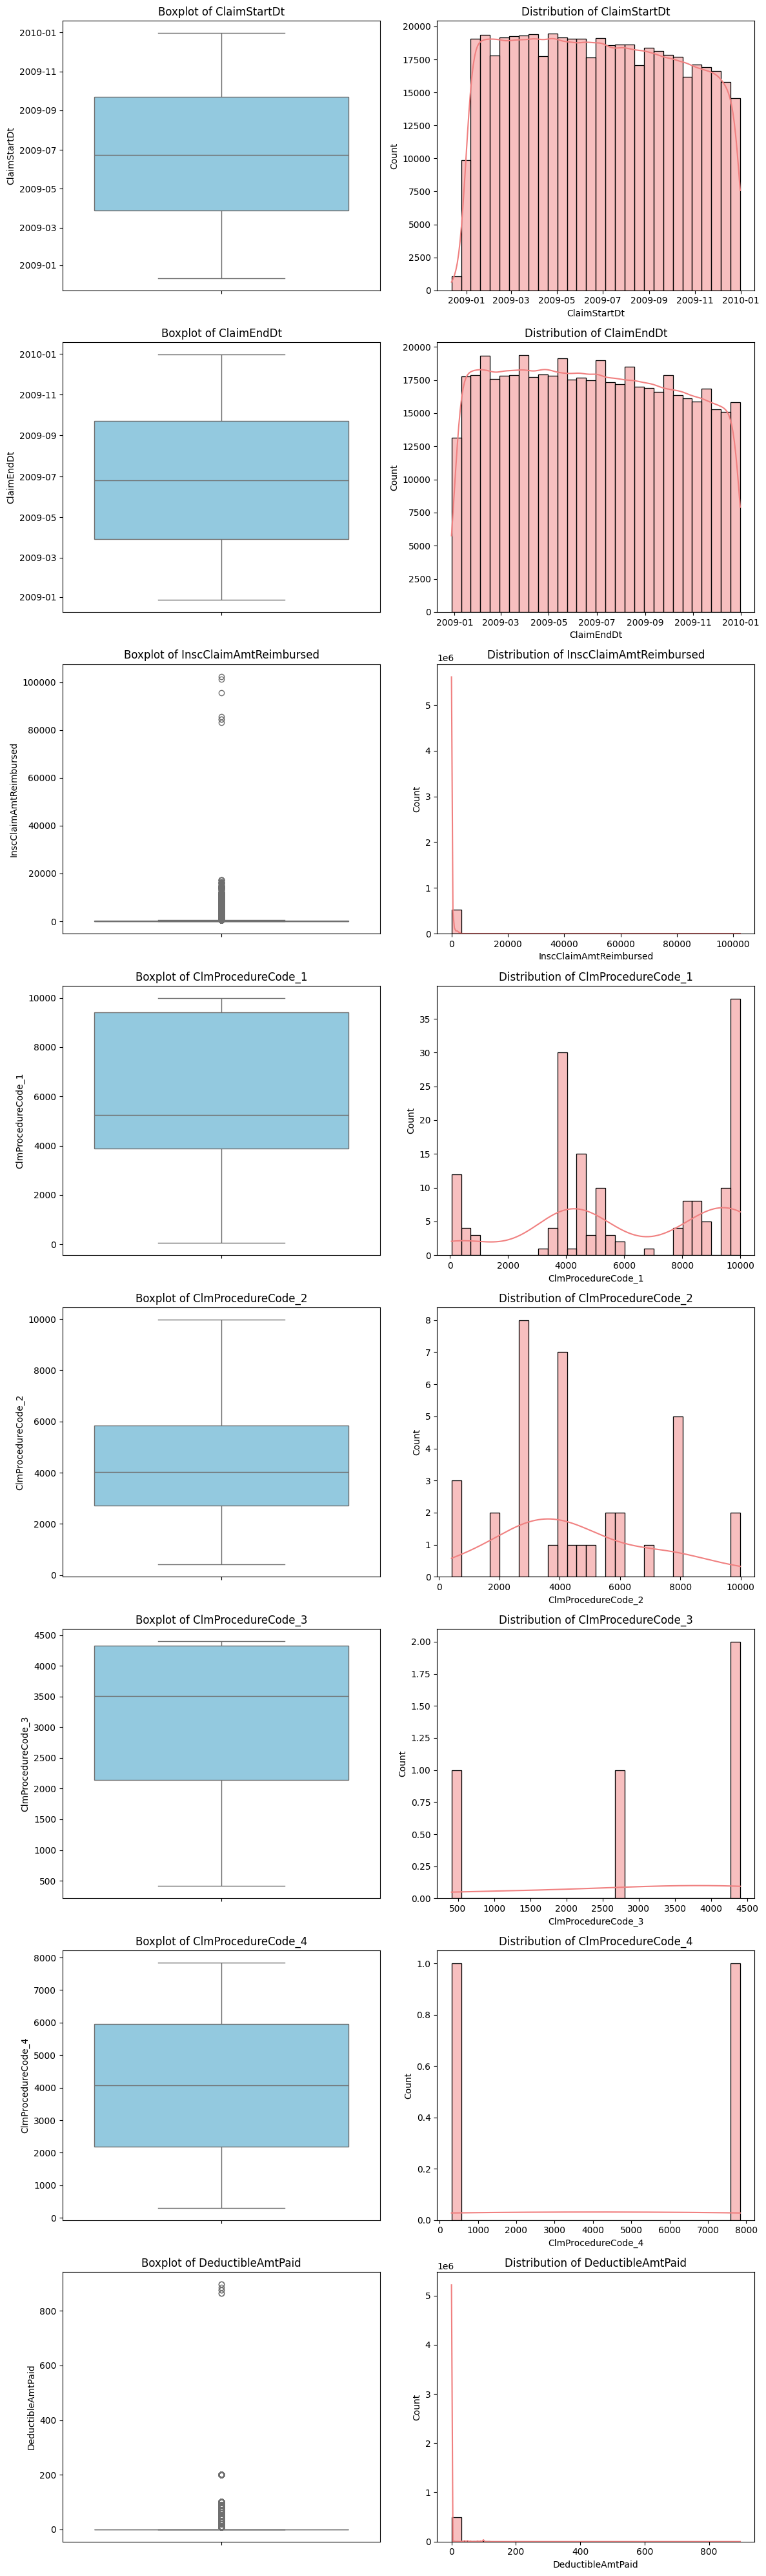

Categorical Disribution Analysis:


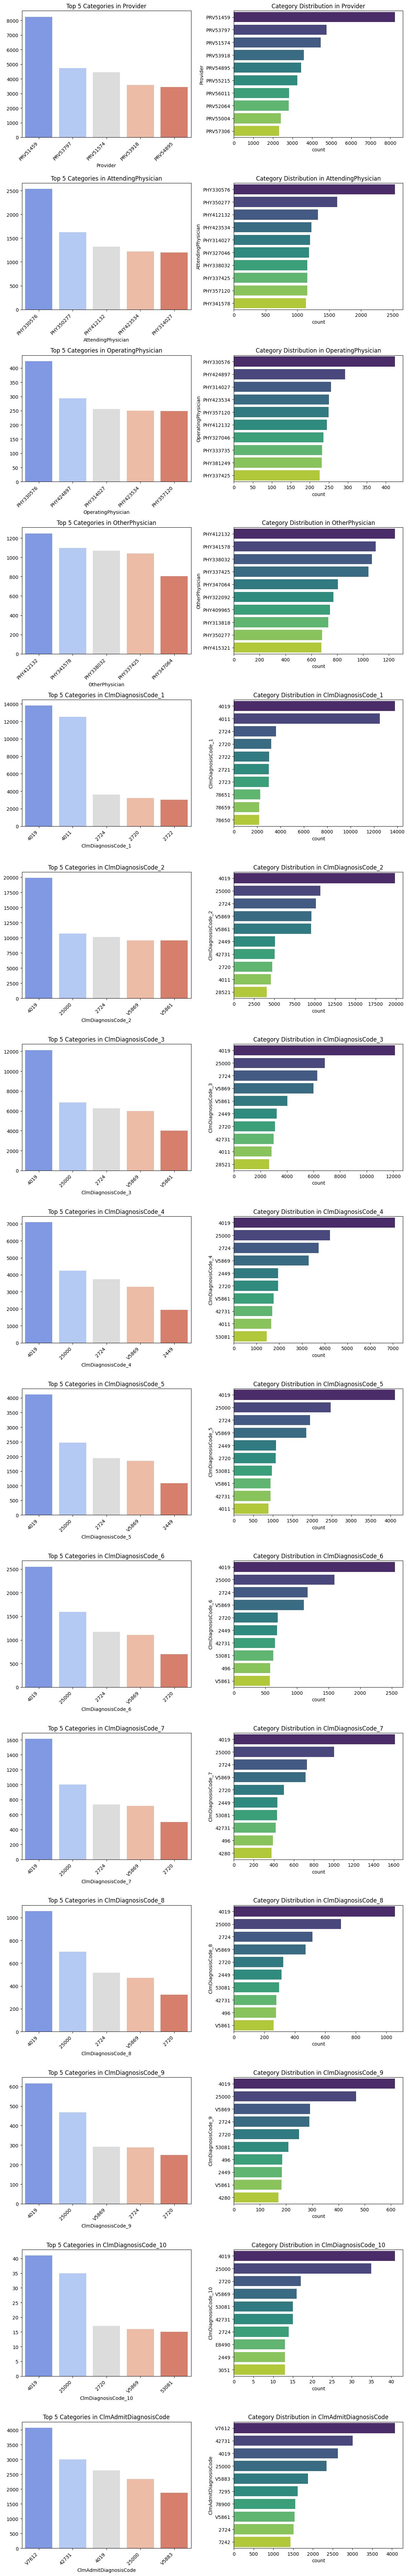

Final Summary:

=== Attribute Characteristics for Outpatient (labeled) ===

           Column Name             Type  Missing Values  Missing % Outliers      Distribution
                BeneID Categorical/Text               0       0.00      N/A  Categorical/Text
               ClaimID Categorical/Text               0       0.00      N/A  Categorical/Text
          ClaimStartDt            Other               0       0.00      N/A  Categorical/Text
            ClaimEndDt            Other               0       0.00      N/A  Categorical/Text
              Provider Categorical/Text               0       0.00      N/A  Categorical/Text
InscClaimAmtReimbursed          Integer               0       0.00    78375     Highly Skewed
    AttendingPhysician Categorical/Text            1396       0.27      N/A  Categorical/Text
    OperatingPhysician Categorical/Text          427120      82.50      N/A  Categorical/Text
        OtherPhysician Categorical/Text          322691      62.33      N/A  C

In [103]:
eda_results(outpatient_labeled, 'Outpatient (labeled)', numerical_cols_labeled, categorical_cols_labeled)

# Outpatient (unlabeled) EDA

In [104]:
outpatient_unlabeled = pd.read_csv('Datasets/Test_Outpatientdata-1542969243754.csv', parse_dates= ['ClaimStartDt', 'ClaimEndDt'])
outpatient_unlabeled.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11001,CLM392397,2009-06-02,2009-06-02,PRV55962,30,PHY347633,NaN,PHY347633,V5832,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1,BENE11001,CLM430760,2009-06-23,2009-06-23,PRV56112,30,PHY381777,NaN,PHY381777,9594,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2,BENE11007,CLM233081,2009-03-07,2009-03-07,PRV56979,200,PHY425311,NaN,PHY425311,7248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11007,CLM496381,2009-07-29,2009-07-29,PRV56573,10,PHY393253,PHY347995,NaN,58889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5939
4,BENE11007,CLM521391,2009-08-12,2009-08-12,PRV56573,10,PHY417685,NaN,PHY382041,V666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [105]:
numerical_cols_unlabeled = ['ClaimStartDt', 'ClaimEndDt', 'InscClaimAmtReimbursed', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid']

categorical_cols_unlabeled = ['Provider', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmAdmitDiagnosisCode']

=== EDA Summary for Outpatient (unlabeled) ===

Shape: (125841, 27)
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125841 entries, 0 to 125840
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   BeneID                  125841 non-null  object        
 1   ClaimID                 125841 non-null  object        
 2   ClaimStartDt            125841 non-null  datetime64[ns]
 3   ClaimEndDt              125841 non-null  datetime64[ns]
 4   Provider                125841 non-null  object        
 5   InscClaimAmtReimbursed  125841 non-null  int64         
 6   AttendingPhysician      125525 non-null  object        
 7   OperatingPhysician      21604 non-null   object        
 8   OtherPhysician          47619 non-null   object        
 9   ClmDiagnosisCode_1      123263 non-null  object        
 10  ClmDiagnosisCode_2      78110 non-null   object        
 11  ClmDiagnosisCode_

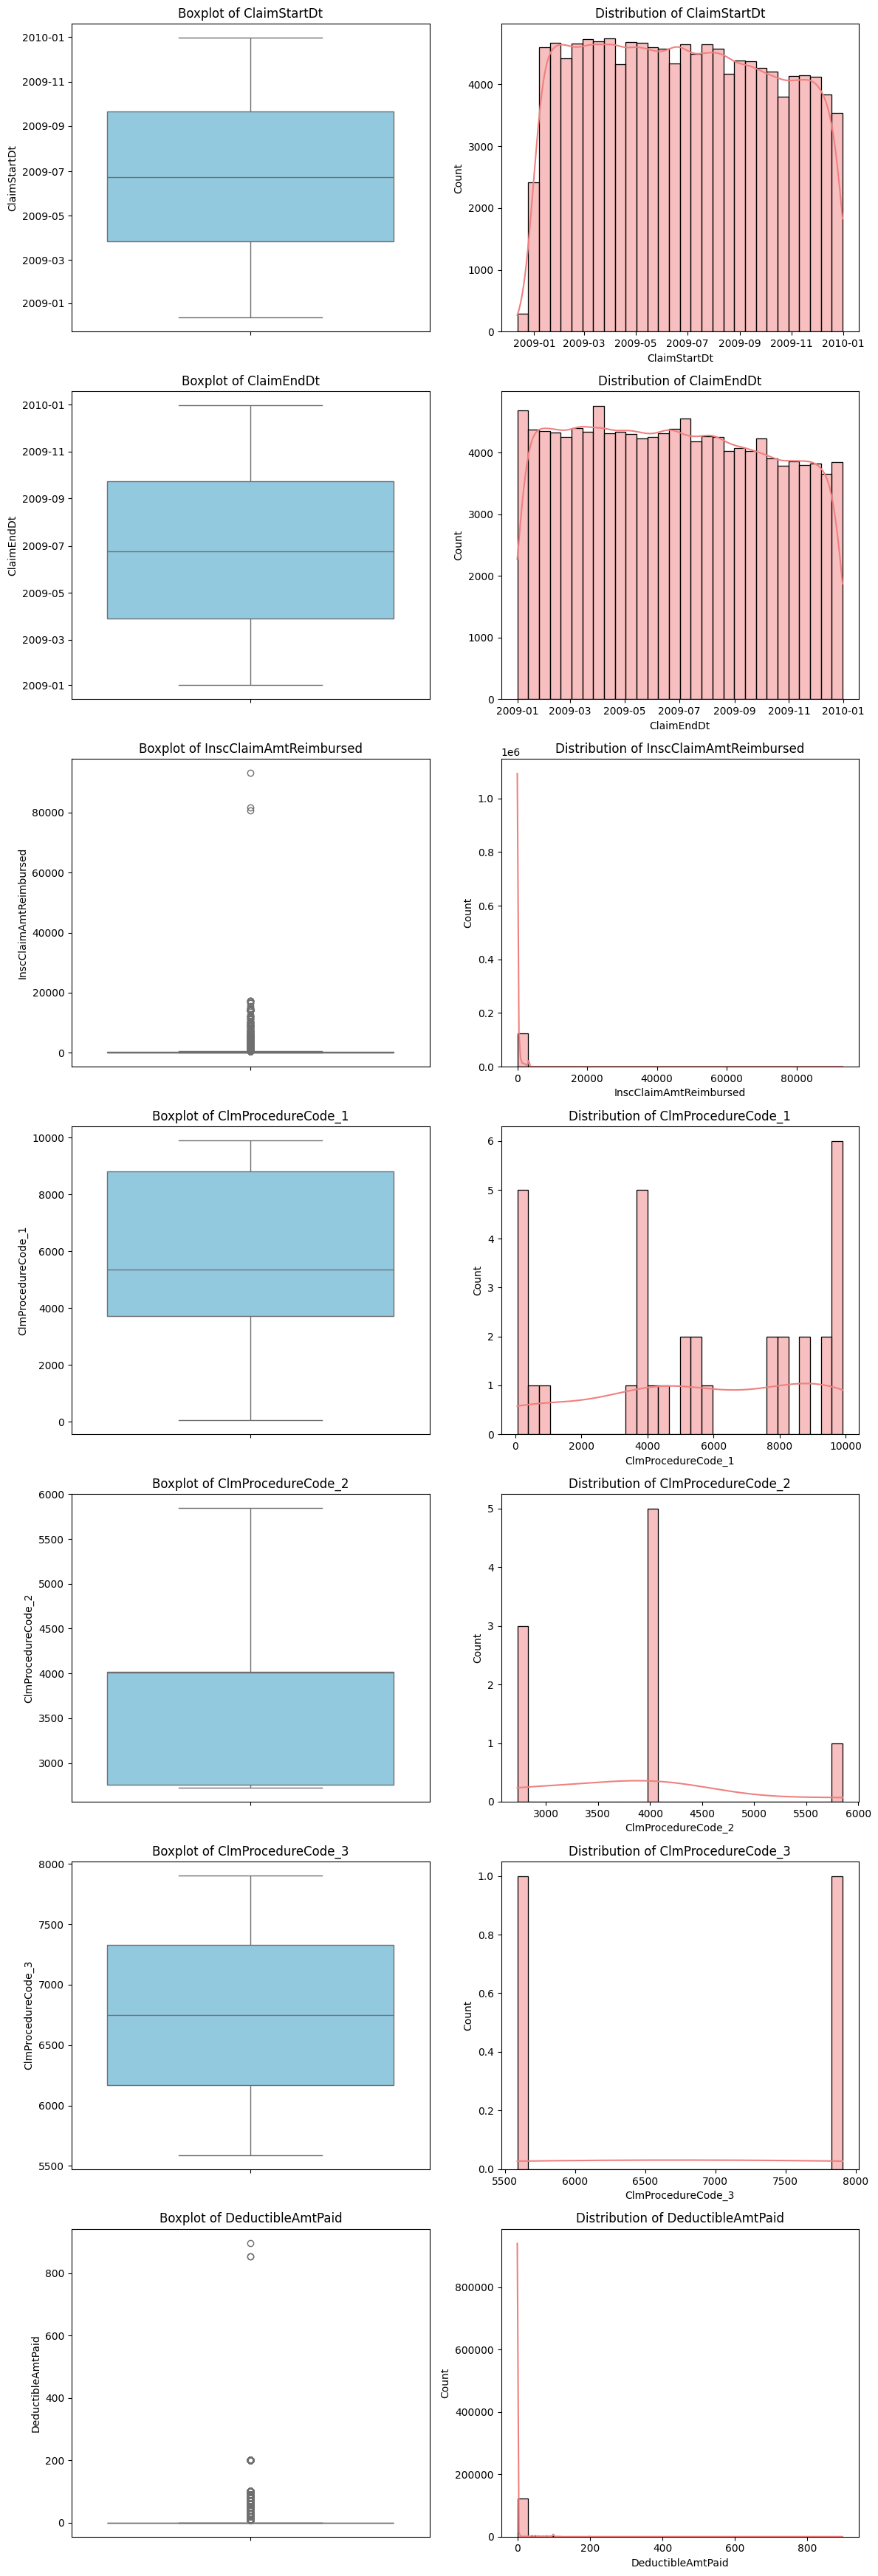

Categorical Disribution Analysis:


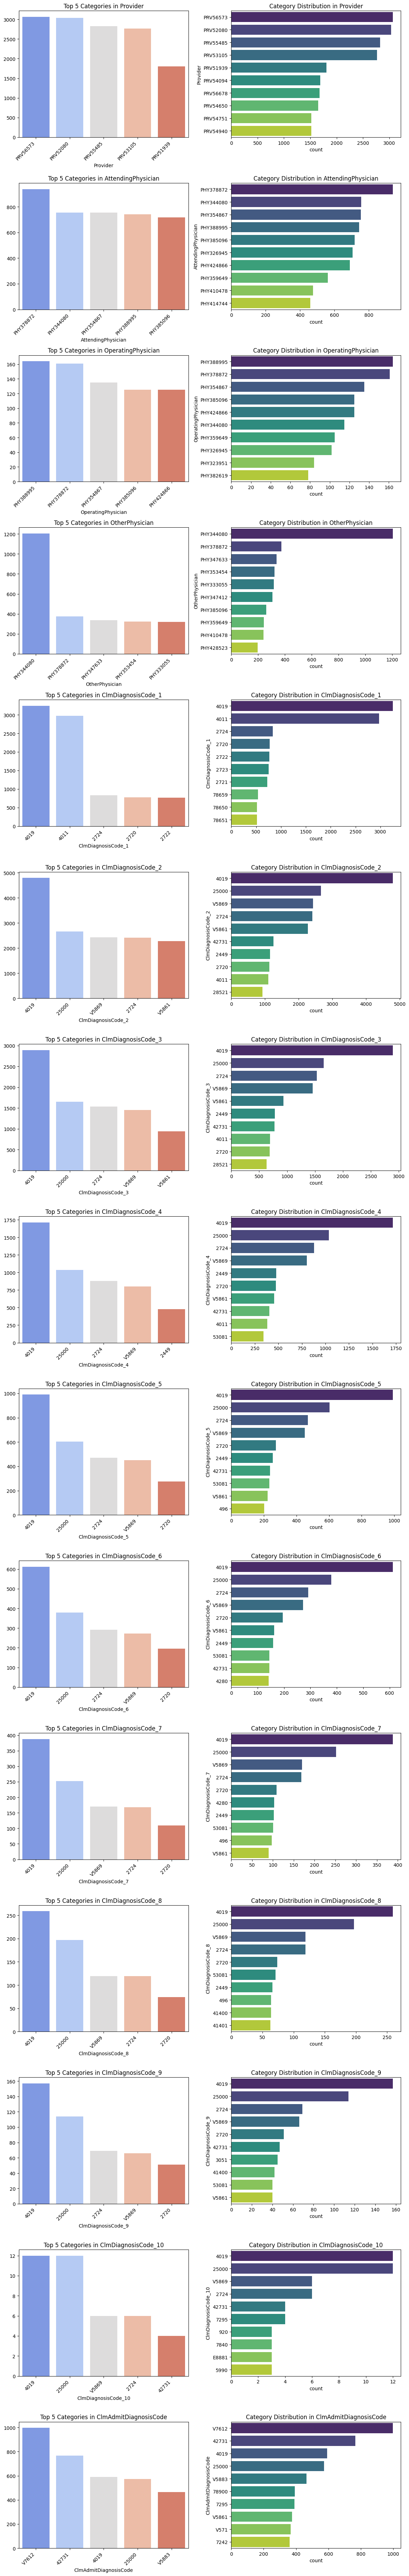

Final Summary:

=== Attribute Characteristics for Outpatient (unlabeled) ===

           Column Name             Type  Missing Values  Missing % Outliers      Distribution
                BeneID Categorical/Text               0       0.00      N/A  Categorical/Text
               ClaimID Categorical/Text               0       0.00      N/A  Categorical/Text
          ClaimStartDt            Other               0       0.00      N/A  Categorical/Text
            ClaimEndDt            Other               0       0.00      N/A  Categorical/Text
              Provider Categorical/Text               0       0.00      N/A  Categorical/Text
InscClaimAmtReimbursed          Integer               0       0.00    19146     Highly Skewed
    AttendingPhysician Categorical/Text             316       0.25      N/A  Categorical/Text
    OperatingPhysician Categorical/Text          104237      82.83      N/A  Categorical/Text
        OtherPhysician Categorical/Text           78222      62.16      N/A 

In [106]:
eda_results(outpatient_unlabeled, 'Outpatient (unlabeled)', numerical_cols_unlabeled, categorical_cols_unlabeled)

# Outpatient (appended) EDA

In [107]:
outpatient_appended = pd.read_csv('Datasets/outpatient_appended.csv', parse_dates= ['ClaimStartDt', 'ClaimEndDt'])
outpatient_appended.head()

,Unnamed: 0,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,0,BENE11001,CLM392397,2009-06-02,2009-06-02,PRV55962,30,PHY347633,NaN,PHY347633,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1,1,BENE11001,CLM430760,2009-06-23,2009-06-23,PRV56112,30,PHY381777,NaN,PHY381777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
2,2,BENE11007,CLM233081,2009-03-07,2009-03-07,PRV56979,200,PHY425311,NaN,PHY425311,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,3,BENE11007,CLM496381,2009-07-29,2009-07-29,PRV56573,10,PHY393253,PHY347995,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5939
4,4,BENE11007,CLM521391,2009-08-12,2009-08-12,PRV56573,10,PHY417685,NaN,PHY382041,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [108]:
numerical_cols_appended = ['ClaimStartDt', 'ClaimEndDt', 'InscClaimAmtReimbursed', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid']

categorical_cols_appended = ['Provider', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmAdmitDiagnosisCode']

=== EDA Summary for Outpatient (appended) ===

Shape: (125841, 27)
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125841 entries, 0 to 125840
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   BeneID                  125841 non-null  object        
 1   ClaimID                 125841 non-null  object        
 2   ClaimStartDt            125841 non-null  datetime64[ns]
 3   ClaimEndDt              125841 non-null  datetime64[ns]
 4   Provider                125841 non-null  object        
 5   InscClaimAmtReimbursed  125841 non-null  int64         
 6   AttendingPhysician      125525 non-null  object        
 7   OperatingPhysician      21604 non-null   object        
 8   OtherPhysician          47619 non-null   object        
 9   ClmDiagnosisCode_1      123263 non-null  object        
 10  ClmDiagnosisCode_2      78110 non-null   object        
 11  ClmDiagnosisCode_3

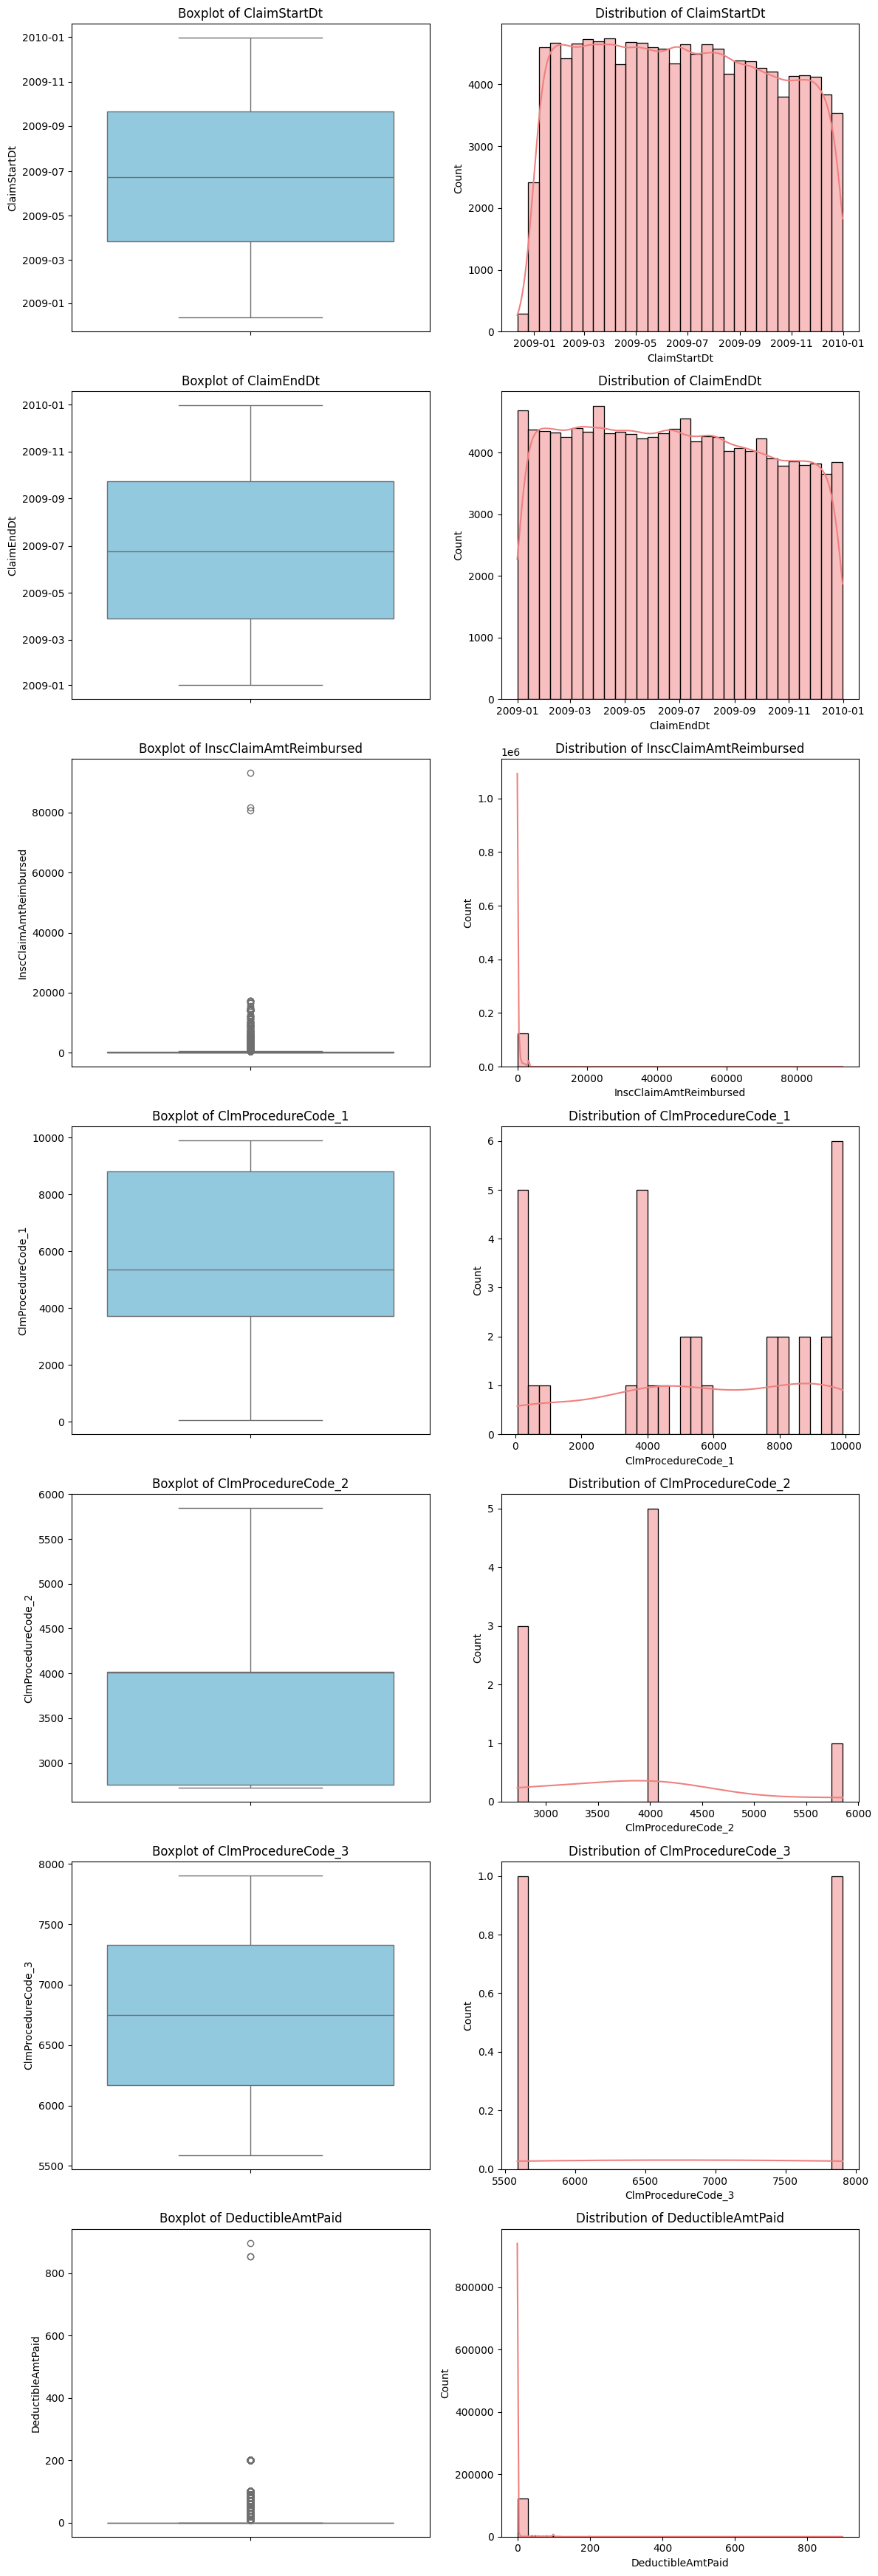

Categorical Disribution Analysis:


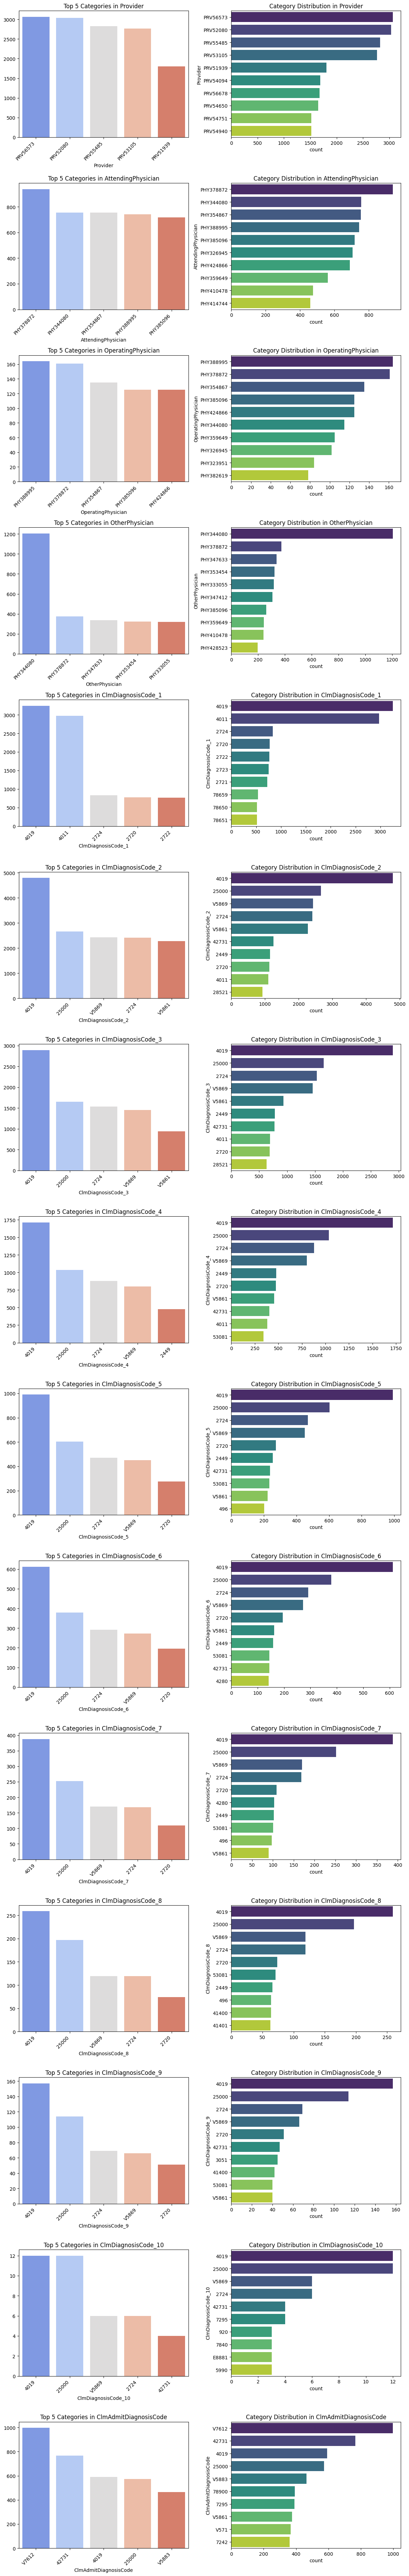

Final Summary:

=== Attribute Characteristics for Outpatient (appended) ===

           Column Name             Type  Missing Values  Missing % Outliers      Distribution
                BeneID Categorical/Text               0       0.00      N/A  Categorical/Text
               ClaimID Categorical/Text               0       0.00      N/A  Categorical/Text
          ClaimStartDt            Other               0       0.00      N/A  Categorical/Text
            ClaimEndDt            Other               0       0.00      N/A  Categorical/Text
              Provider Categorical/Text               0       0.00      N/A  Categorical/Text
InscClaimAmtReimbursed          Integer               0       0.00    19146     Highly Skewed
    AttendingPhysician Categorical/Text             316       0.25      N/A  Categorical/Text
    OperatingPhysician Categorical/Text          104237      82.83      N/A  Categorical/Text
        OtherPhysician Categorical/Text           78222      62.16      N/A  

In [109]:
eda_results(outpatient_unlabeled, 'Outpatient (appended)', numerical_cols_appended, categorical_cols_appended)